In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, svm
from sklearn.metrics import accuracy_score
import re
import fasttext
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from IPython.display import display, HTML
import seaborn as sns
import urllib.request as urllib2
from bs4 import BeautifulSoup

## Data Cleaning

In [2]:
data = pd.read_csv("people_ask.csv")

In [3]:
# train/valid/test = 0.8/0.1/0.1

def clean_text(text):
    cleaned_text = re.sub(r'[^A-Za-z0-9 ]+', '', text)
    return cleaned_text.lower()
    
def clean_instances(data):
    instances = data["sentence"]
    labels = data["is_instance"]
    
    labels = ["instance" if l else "not_instance" for l in labels]
    
    cleaned_instances = [clean_text(inst) for inst in instances]
    
    df_new = pd.DataFrame(columns = data.columns)
    df_new[data.columns] = data[data.columns]
    df_new["sentence"] = cleaned_instances
    
    df_new["is_instance"] = labels
    
    return df_new


data_clean = clean_instances(data)

train_text, truth_text, train_labels, truth_labels = train_test_split(data_clean["sentence"], data_clean["is_instance"], test_size = 0.1, shuffle = True)
train_text, test_text, train_labels, test_labels = train_test_split(train_text, train_labels, test_size = 1/9, shuffle = True)

train_text, test_text, truth_text = train_text.to_numpy(), test_text.to_numpy(), truth_text.to_numpy()
train_labels, test_labels, truth_labels = train_labels.to_numpy(), test_labels.to_numpy(), truth_labels.to_numpy()

In [4]:
fasttext_data_train = [f"__label__{train_labels[i]} {train_text[i]}" for i in range(len(train_labels))]
fasttext_data_test = [f"__label__{test_labels[i]} {test_text[i]}" for i in range(len(test_labels))]
fasttext_data_truth = [f"__label__{truth_labels[i]} {truth_text[i]}" for i in range(len(truth_labels))]

train_file = open("model.train", "w+")
test_file = open("model.valid", "w+")
truth_file = open("model.truth", "w+")

train_file.write("\n".join(fasttext_data_train))
test_file.write("\n".join(fasttext_data_test))
truth_file.write("\n".join(fasttext_data_truth))

train_file.close()
test_file.close()
truth_file.close()

## Parameter Selection

In [5]:
cv_data = []

for lr in np.arange(0, 1, 0.05):
    row = []
    for epochs in range(5, 35, 5):
        model_cv = fasttext.train_supervised(input = "model.train", lr = lr, epoch = epochs)
        p = model_cv.test("model.valid")[1]
        row.append(p)
    cv_data.append(row)

<AxesSubplot:>

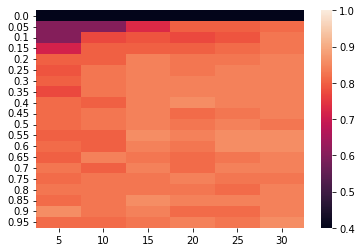

In [6]:
sns.heatmap(cv_data, vmin = np.min(cv_data), vmax = 1, xticklabels = np.arange(5, 35, 5), yticklabels = np.arange(0, 1, 0.05).round(3))

In [7]:
max_idx = np.unravel_index(np.array(cv_data).argmax(), np.array(cv_data).shape)
best_learning_rate = np.arange(0, 1, 0.05)[max_idx[0]]
best_epochs = np.arange(5, 35, 5)[max_idx[1]]
max_p = cv_data[max_idx[0]][max_idx[1]]

print(f"Best Learning Rate: {best_learning_rate}\nBest Number of Epochs: {best_epochs}\nMax Precision/Recall: {max_p}")

Best Learning Rate: 0.4
Best Number of Epochs: 20
Max Precision/Recall: 0.8571428571428571


In [8]:
def create_confusion_mat(text, labels, m):
    
    df = pd.DataFrame(confusion_matrix([str(l) for l in labels], [m.predict(t)[0][0][len("__label__"):] for t in text]), index = ["Actual Not Instance", "Actual Instance"])
    df.columns = ["Predicted Not Instance", "Predicted Instance"]
                  
    return df

def print_precision_recall(filename, m):
    n, p, r = m.test(filename)
    print(f"Results for {filename}\nPrecision: {p} | Recall: {p}\n\n")

## Analyzing Results

In [9]:
model_cv = fasttext.train_supervised(input = "model.train", lr = best_learning_rate, epoch = best_epochs)

In [10]:
for fn in ["model.train", "model.valid", "model.truth"]:
    print_precision_recall(fn, model_cv)

Results for model.train
Precision: 1.0 | Recall: 1.0


Results for model.valid
Precision: 0.8428571428571429 | Recall: 0.8428571428571429


Results for model.truth
Precision: 0.8714285714285714 | Recall: 0.8714285714285714




In [11]:
display(HTML('<b>Training Data Confusion Matrix</b>'))
create_confusion_mat(train_text, train_labels, model_cv)

,Predicted Not Instance,Predicted Instance
Actual Not Instance,154,0
Actual Instance,0,399


In [12]:
display(HTML('<b>Validation Data Confusion Matrix</b>'))
create_confusion_mat(test_text, test_labels, model_cv)

,Predicted Not Instance,Predicted Instance
Actual Not Instance,19,9
Actual Instance,2,40


In [13]:
display(HTML('<b>Testing Data Confusion Matrix</b>'))
create_confusion_mat(truth_text, truth_labels, model_cv)

,Predicted Not Instance,Predicted Instance
Actual Not Instance,11,7
Actual Instance,2,50


## Predicting on the Web

In [27]:
def answer(url, tol):
    
    hdr = {'User-Agent': 'Mozilla/5.0'}
    req = urllib2.Request(url, headers = hdr)
    page = urllib2.urlopen(req)
    soup = BeautifulSoup(page, "html.parser")
    
    paragraphs_web = soup.findAll("p")
    paragraphs_web = [p.text for p in paragraphs_web]
    
    response = []

    for p in paragraphs_web:
        sentences = [s for s in nltk.sent_tokenize(p)]
        sentences_cleaned = [clean_text(s) for s in sentences]

        pred = [(model_cv.predict(s)[0][0][len("__label__"):] == 'instance', model_cv.predict(s)[1][0]) for s in sentences_cleaned]
        labels = ["I" if label and score > tol else "N" for label, score in pred]
        
        chunks = []
        for i in range(len(sentences)):
            if labels[i] == "I":
                chunks.append(sentences[i])
        
        if len(chunks) > 0:
            chunk_text = [c for c in chunks]
            response.append(" ".join(chunk_text))
    
        
    return "\n".join(response)

In [28]:
print(answer("https://www.dataversity.net/a-brief-history-of-machine-learning/", 0.98))

Until the late 1970s, it was a part of AI’s evolution.
The model was created in 1949 by Donald Hebb in a book titled The Organization of Behavior (PDF).
Arthur Samuel of IBM developed a computer program for playing checkers in the 1950s.
Arthur Samuel first came up with the phrase “machine learning” in 1952.
Described as the first successful neuro-computer, the Mark I perceptron developed some problems with broken expectations.
In 1967, the nearest neighbor algorithm was conceived, which was the beginning of basic pattern recognition.
Additionally, neural network research was abandoned by computer science and AI researchers.
The concept of boosting was first presented in a 1990 paper titled “The Strength of Weak Learnability,” by Robert Schapire.


In [29]:
print(answer("https://www.forbes.com/sites/bernardmarr/2016/02/19/a-short-history-of-machine-learning-every-manager-should-read/?sh=2474976115e7", 0.8))

1950 — Alan Turing creates the “Turing Test” to determine if a computer has real intelligence.
1952 — Arthur Samuel wrote the first computer learning program. The program was the game of checkers, and the 
 
IBM
 computer improved at the game the more it played, studying which moves made up winning strategies and incorporating those moves into its program.
1957 — Frank Rosenblatt designed the first neural network for computers (the perceptron), which simulate the thought processes of the human brain.
1967 — The “nearest neighbor” algorithm was written, allowing computers to begin using very basic pattern recognition.
1997 — IBM’s Deep Blue beats the world champion at chess.
2011 — IBM’s Watson beats its human competitors at Jeopardy.
The AlphaGo algorithm developed by Google DeepMind managed to win five games out of five in the Go competition.


In [33]:
print(answer("https://concisesoftware.com/history-of-machine-learning/", 0.99))

Who was the first person to create the concept of a self-learning machine?
The test was designed to determine whether a computer has human-like intelligence.
1952 – Arthur Samuels, the American pioneer in the field of artificial intelligence and computer gaming, wrote the very first computer learning program.
1967 – The nearest neighbor algorithm was written for the first time this year.
The 1990s – during the 1990s, the work in machine learning shifted from the knowledge-driven approach to the data-driven approach.
For starters, IBM’s Watson managed to beat human competitors at Jeopardy.
2016 – this was the year when Google’s artificial intelligence algorithms managed to beat a professional player at the Chinese board game Go.
Natural language processing (NLP)
